In [1]:
import utils, shapely_utils as shu, python_utils as pu, cairo_utils as cu, plotter_utils as plu
import bezier
import numpy as  np
from shapely import LineString, MultiLineString, GeometryCollection
import shapely as sh


In [2]:
# pip install scipy

In [3]:
# imports
from pathlib import Path, PurePath
import sys

In [4]:
def bball_net(radius,m=0.15,n=0.25,total_slices=12,len_straight=4, prop_h=0.5):
    curve = bezier.Curve(np.asfortranarray(np.matrix([[0,0],[n/4,m],[n,prop_h*m]]).transpose()), degree=2)
    line = LineString([[-n/3,-n/len_straight],[0,0]])
    # return line
    l = sh.line_merge(MultiLineString([line,shu.curve_to_ls(curve)]))
    # return line
    a,b,c,d = l.bounds
    x_dist = c-a
    y_dist = d-b
    w_line,h_line = shu.size(line)
    
    p = sh.line_merge(MultiLineString([l,sh.affinity.translate(sh.affinity.scale(l, -1, 1),x_dist)]))
    # return l
    # return p
    w,h = shu.size(p)
    scale_prop = radius/w
    p = sh.affinity.scale(p, scale_prop, scale_prop)
    p2 = sh.affinity.translate(sh.affinity.scale(p, 1, -1),0,- h * scale_prop + h_line*scale_prop*2)
    lip = GeometryCollection([p,p2])
    # return lip
    # return lip
    # return lip
    tots_lips = []
    mergers_entre_lips = []
    def getLines(last_line, new_line):
        line = LineString([list(list(new_line.geoms)[1].coords)[0],list(list(last_line.geoms)[0].coords)[0]])
        line2 = LineString([list(list(new_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[1].coords)[-1]])
        return [line, line2]
    first_line = None
    for i in range(int(total_slices/2)):
        new_line = sh.affinity.rotate(lip, i*(360/total_slices))
        if (i>0):
            mergers_entre_lips += getLines(last_line, new_line)
        else:
            first_line = new_line
        tots_lips.append(new_line)
        last_line = new_line
    # inverse
    line = LineString([list(list(first_line.geoms)[1].coords)[0],list(list(last_line.geoms)[1].coords)[-1]])
    line2 = LineString([list(list(first_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[0].coords)[0]])
    mergers_entre_lips += [line, line2]
    # return tots_lips
    # print(len(tots_lips))
    # return [tots_lips,mergers_entre_lips]
    return shu.StructuredCollection(lips=tots_lips, lips_mergers=mergers_entre_lips)

In [5]:
# pu.chunk_list

In [6]:
# upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
# upB['lips_mergers']
#si poso 10 tot palma

In [7]:
# bball_net(50, 0.15,0.25,8,3.7,0.85).geo

# aw.upper_bball

In [8]:
upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
downB = bball_net(50, 0.15,0.25,10,3.7,0.85).translate(0,-100)

# downB2 = bball_net(50, 0.15,0.25,12,3.7,0.85).translate(0,90)
# shu.printg([upB.geo, downB.geo])

In [9]:
# SPRINGs
# top_mergers = 5
# top_mergers_up = shu.reorder_geos(upB['lips_mergers'], "S", top_mergers)
# top_mergers_down = shu.reorder_geos(downB['lips_mergers'], "N", top_mergers)
# springs_top = []
# springs_bottom = []
# for i in range(top_mergers):
#     l1 = top_mergers_up.geoms[i]
#     extra_first=2
#     extra_last=2
#     if not shu.in_axis(shu.first(l1),shu.last(l1)):
#         if shu.get_quadrant(shu.first(l1),shu.last(l1))%2==0:
#             extra_first=4
#             extra_last=2
#         else:
#             extra_last=4
#             extra_first=2
#     spring_l1 = shu.spring(l1,3,1,0.8,True,extra_first,extra_last)
#     springs_top.append(spring_l1)
#     l2 = top_mergers_down.geoms[i]
#     spring_l2 = shu.spring(l2,3,1,0.8,True,extra_first,extra_last)
#     springs_bottom.append(spring_l2)

In [10]:
# last = None
# first_item = None
# guides = []
# for i,springs in enumerate(shu.iter_two(flow_total)):
#     s1, s2 = springs
#     if (not last is None):
#         guides.append(LineString([last, shu.first(s1)]))
#     guides.append(LineString([shu.last(s1), shu.first(s2)]))
#     last = shu.last(s2)
# last = None
first_item = None
guides = []
top_mergers = 5
top_mergers_up = shu.reorder_geos(shu.geoms(upB['lips_mergers']), "S", top_mergers)
# estirals explotals TODO
scale_factor = 2
# top_mergers_up = [sh.affinity.scale(sh.affinity.translate(m,0,-6),scale_factor) for m in top_mergers_up]
top_mergers_down = shu.reorder_geos(shu.geoms(downB['lips_mergers']), "N", top_mergers)
# top_mergers_down = [sh.affinity.scale(sh.affinity.translate(m,0,6),scale_factor) for m in top_mergers_down]
for i,springs in enumerate(zip(shu.reorder_geos(top_mergers_up, "E"), shu.reorder_geos(top_mergers_down, "E"))):
    s1, s2 = springs
    # if (not last is None):
    guides.append(LineString([shu.first(s1), shu.last(s2)]))
    guides.append(LineString([shu.last(s1), shu.first(s2)]))
    # last = shu.last(s2)
force_middle = 0.5
force_second = 0.72
field = [0,0,force_second, force_second,force_middle,force_middle,force_second, force_second,0,0]
guides = [shu.deform_line(g, GeometryCollection(guides).centroid, 0.3+field[i]*0.2) for i,g in enumerate(guides)]

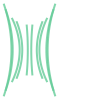

In [11]:
shu.printg(*guides)

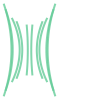

In [12]:
shu.printg(*guides)

In [13]:
# force_y = shu.create_peak_function(5)
# [shu.gaussian_generator(x_max=2)(i)**0.08 for i in range(5)]

In [14]:
import random
random.seed(10)
curves = []
trenes = []
# right_lines = []
force_y = lambda x: shu.gaussian_generator(x_max=2)(i)**0.5
for j,g in enumerate(pu.chunk_list(guides,2)):
    trena = []
    # print(i)
    other_guide = g[0]
    guide = g[1]
    if g[0].length>g[1].length:
        guide = g[0]
        other_guide = g[1]
    segments = shu.segmentize(guide, 5).geoms
    other_segments = shu.segmentize(other_guide, 5).geoms
    initial_coords = [shu.first(g[0]),shu.first(g[1])]
    last = None
    last_coords = [shu.last(g[0]),shu.last(g[1])]
    # print(len(segments))
    for i in range(len(segments)):
        segment = segments[i]
        other_segment = other_segments[i]
        total = 2+force_y(j)*2
        curves_el = None
        
        if (i==0):
            initial_coords = shu.reorder_geos([sh.Point(v) for v in initial_coords], "O")
            centroid_segments = LineString([shu.last(segment),shu.last(other_segment)]).centroid
            curves_el = shu.create_ellipse(initial_coords[0],centroid_segments, total, initial_coords[1])
            curves += curves_el
            last = centroid_segments
        elif (i==len(segments)-1):
            centroid_segments = LineString([shu.first(segment),shu.first(other_segment)]).centroid
            last_coords = shu.reorder_geos([sh.Point(v) for v in last_coords], "E")
            curves_el = shu.create_ellipse(last_coords[0], centroid_segments, total, last_coords[1])
            curves += curves_el
        else:
            centroid_segments = LineString([shu.last(segment),shu.last(other_segment)]).centroid
            curves_el = shu.create_ellipse(last, centroid_segments, total)
            curves += curves_el
            last = centroid_segments
        
        lines_in_between = 5
        # curv1, curv2 = curves[-2],curves[-1]
        trena.append(curves_el)
        # trena.append(curv2)
        # points_in_curv1 = shu.distribute_points(curv1,lines_in_between)
        # points_in_curv2 = shu.distribute_points(curv2,lines_in_between)
        # for i in range(lines_in_between):
        #     right_lines.append(LineString([points_in_curv1[i],points_in_curv2[i]]))
    trenes.append(trena)
    # for i in range(len(segments1)):
    #     s1 = segments1[i]        
    #     # pot = 1 if (j+i)%2==0 else -1
    #     total = 2+random.random()*3
    #     # total = 3
    #     norm = shu.sum_point_vector(s1.centroid,shu.normal_vector(s1), total )
    #     c = shu.last(norm)
    #     # if (random.random()<0.75):
    #     curv1 = shu.curved_path(shu.first(s1),shu.last(s1), c, 1)
    #     curves.append(curv1)
        
    #     lines_in_between = 10
    #     points_in_curv1 = distribute_points(curv1,lines_in_between)
    #     points_in_curv2 = distribute_points(curv2,lines_in_between)
    #     for i in range(lines_in_between):
    #         right_lines.append(LineString([points_in_curv1[i],points_in_curv2[i]]))
    # else:
    #     curves.append(s)
        
        


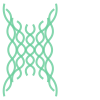

In [15]:
shu.printg(*pu.flat(trenes),)
# TODO la del mig esta torta!

In [16]:
# trenes
scale_factor_lines = 1.2

In [17]:
translate_lines = 25

In [18]:
up_line = sh.affinity.scale(LineString([shu.first(trenes[0][0][1]),shu.first(trenes[-1][0][0])]),scale_factor_lines,0)
up_line = sh.affinity.translate(up_line,0,translate_lines)
half_middle_upper = LineString([shu.first(trenes[2][0][1]),shu.first(trenes[2][0][0])])
curved_up = shu.curved_path(shu.first(up_line),shu.last(up_line),half_middle_upper.centroid)
# curved_up = sh.affinity.translate(curved_up, 0, -8)
# shu.printg(*([up_line,half_middle_upper]+curves))

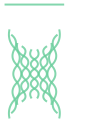

In [19]:
# sh.affinity.scale(curved_up, 1.2, 1.2)
shu.printg(*pu.flat(trenes),up_line)

In [20]:
shu.gaussian_generator(x_max=2)(5)

0.011108996538242306

In [21]:
down_line = sh.affinity.scale(LineString([shu.first(trenes[0][-1][0]),shu.first(trenes[-1][-1][1])]),scale_factor_lines,0)
down_line = sh.affinity.translate(down_line,0,-translate_lines)
half_middle_down= LineString([shu.first(trenes[2][-1][0]),shu.first(trenes[2][-1][1])])
# shu.printg(*([down_line,half_middle_down]+curves))
curved_down = shu.curved_path(shu.first(down_line),shu.last(down_line),half_middle_down.centroid)
# curved_down = sh.affinity.translate(curved_down, 0, 8)

In [22]:
translate_distance = sh.distance(half_middle_down,half_middle_upper)

In [23]:
def segmentize_and_rotate(l, num_segments, scale_factor=0.8, max_angle=60, invert=False):
    all_segments = []
    next_scaled_2_shape = None
    try:  
        for a in shu.geoms(shu.segmentize(l,num_segments)):
            
                scale_each = scale_factor/2
                if invert:
                    scaled_1_shape = shu.sliceCurve(a, 0,scale_each)
                    newLine = scaled_1_shape
                    if not next_scaled_2_shape is None:
                        newLine = shu.LineString((shu.coords(next_scaled_2_shape)+shu.coords(scaled_1_shape)))
                        all_segments.append(newLine)
                    else:
                        all_segments.append(newLine)
                    next_scaled_2_shape = shu.sliceCurve(a, 1-scale_each,1)
                else:    
                    # final_shape = sh.affinity.scale(a,scale_factor,scale_factor)
                    scaled_shape = shu.sliceCurve(a, 0.5-scale_each,0.5+scale_each)
                    final_shape = sh.affinity.rotate(scaled_shape,(random.random()-0.5)*(max_angle))
                    all_segments.append(final_shape)
    except:
       pass
    if invert:
        all_segments.append(next_scaled_2_shape)
    return shu.printg(*all_segments)

In [24]:
# segmentize_and_rotate(curved_down,5,0.2,0,False)

In [25]:
# segmentize_and_rotate(curved_down,5,0.2,0,True)

In [26]:
# list(force_iterator(shu.geoms(waves_up), force_lines, ))
# waves_up

In [27]:
number_lines = 30
waves_up = shu.printg(*shu.repeat_geometry_along_path(curved_up,sh.shortest_line(curved_up,curved_down),number_lines))
waves_down = shu.printg(*shu.repeat_geometry_along_path(curved_down,sh.shortest_line(curved_up,curved_down),number_lines))
# waves_up = sh.affinity.translate(waves_up,0,0.4)
force_lines = shu.linear_generator(x_max=int(number_lines))
waves_up = shu.printg(*[segmentize_and_rotate(u,10+30*f,0.8,0) for u,f in shu.force_iterator(shu.geoms(waves_up), force_lines)])
waves_down = shu.printg(*[segmentize_and_rotate(u,10+30*f,0.8,0,) for u,f in shu.force_iterator(shu.geoms(waves_down)[::-1], force_lines)])

In [28]:
waves_down = sh.affinity.translate(waves_down,0,-1)
# waves_up

In [29]:
all_polygons = []
all_cs = []
i = 0
for t in trenes:
    for cs in t:
        c1,c2=cs
        boundary = [c1.reverse(), c2]
        all_cs.append(boundary)
        polygon = sh.Polygon(shu.line_merge(boundary).buffer(0.1).exterior)
        if not polygon.is_simple:
            print('bad',i)
            # break
        all_polygons.append(polygon)
        i+=1
intersected_up = []
for i,p in enumerate(all_polygons):
    for line in shu.geoms(waves_up):
      try:
        intersection = sh.intersection(p, line)
        if not intersection.is_empty:
          intersected_up.append(intersection)
        
      except:
        print('error',i) 
intersected_down = []
for i,p in enumerate(all_polygons):
    for line in shu.geoms(waves_down):
      try:
        intersection = sh.intersection(p, line)
        if not intersection.is_empty:
          intersected_down.append(intersection)
      except:
        print('error',i) 

In [30]:

# Example usage:
# my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pu.reload(shu)
# print(split_randomly_equal(my_list, 3))

In [31]:
# aw = shu.StructuredCollection()

In [32]:
# aw.self_dict

In [33]:
# aw['upper_bball'] = upB.geo

In [35]:
# sh.affinity.scale(shu.printg(*shu.flatten(intersected_up)),10,10)
aw = pu.DotMap()
aw.upper_bball = upB.geo
aw.lower_bball = downB.geo

In [36]:
aw.intersected_up = intersected_up
aw.intersected_down = intersected_down

In [37]:
# aw.intersected_up_1,aw.intersected_up_2,aw.intersected_up_3,aw.intersected_up_4 = pu.split_randomly(shu.flatten(intersected_up),4)
# aw.intersected_down_1,aw.intersected_down_2,aw.intersected_down_3,aw.intersected_down_4 = pu.split_randomly(shu.flatten(intersected_down),4)

In [38]:
# aw.intersected_up_front = intersected_up_front
# aw.intersected_up_back = intersected_up_back
# # aw.curves_down = intersected_down
# aw.intersected_down_front = intersected_down_front
# aw.intersected_down_back = intersected_down_back
# del aw.curves_down
# sh.affinity.scale(shu.printg(*(aw.intersected_up_1+aw.intersected_up_2+aw.intersected_up_3+aw.intersected_up_4)),10,10)

In [39]:
upB_lips_mergers = shu.reorder_geos(shu.geoms(upB['lips_mergers']), "N", top_mergers)

In [40]:
downB_lips_mergers = shu.reorder_geos(shu.geoms(downB['lips_mergers']), "S", top_mergers)

In [41]:
upB['lips_mergers'] = shu.printg(*upB_lips_mergers)
downB['lips_mergers'] = shu.printg(*downB_lips_mergers)
# downB.refresh_geo()

In [42]:
aw.upper_bball = upB.geo
aw.lower_bball = downB.geo

In [43]:
aw.trenes = shu.printg(*pu.flat(trenes))

In [44]:
colored = {
    'upper_bball':'white', 
    'lower_bball':'white', 
    'intersected_up':'blue', 
    'intersected_down':'red', 
    'background': 'green',
    'trenes': "white"
}

In [43]:
pu.reload(shu)

In [45]:
collection = shu.StructuredCollection(**aw)

In [46]:
150/20

7.5

In [47]:
collection.scale(1/7.5,1/7.5)
shu.size(collection.geo)

(6.858403287825267, 20.10084715454969)

In [48]:
# aw

In [49]:
def create_artwork(plotter, aw, colored_, x_margin=0.2,y_margin=0.2):
    colored = colored_
    geo = shu.printg(*pu.flat(aw.values()))
    xmin,ymin,xmax,ymax = geo.bounds
    xmin = min(xmin,0)
    ymin = min(ymin,0)
    extra_x = abs(xmin)
    extra_y = abs(ymin)
    # geo = sh.affinity.translate(geo, , abs(ymin))
    # xmin,ymin,xmax,ymax = geo.bounds
    # geo_width,geo_height  = (abs(xmax-xmin),abs(ymax-ymin))
    geo_width,geo_height = shu.size(geo)
    x_margin_total = x_margin*geo_width
    y_margin_total = y_margin*geo_height
    marc_width = geo_width+2*x_margin_total
    marc_height = geo_height+2*y_margin_total
    last_color = ''
    for color_k,color in colored.items():
        if color != last_color:
            plotter.penup()
            val = input("prepare and protect change to "+color)
            if val=='quit':
                break
            plotter.pendown()
            val = input("ready? penup on "+color)
            if val=='quit':
                break
            plotter.penup()
            val = input("ready 2? plot "+color)
            if val=='quit':
                break
        if color_k == 'background':
            continue
        geo_item = aw[color_k]
        if pu.iterable(geo_item):
            geo_item = sh.GeometryCollection(geo_item)
        geo_item = sh.affinity.translate(geo_item, extra_x+x_margin_total,extra_y+y_margin_total)
        plu.plot(plotter, geo_item, )
        last_color = color
    # ctx.set_source_rgba(*color_array)

    # ctx.set_line_width(0.01)

In [50]:
plotter = None
if plotter is None:
    plotter = plu.init_plotter()

In [50]:
# plotter.quit()

In [52]:
# collection.values()
plotter.penup()

In [53]:
create_artwork(plotter, collection, colored, 0.3, 0.3)

In [108]:
# collection['trenes']

In [103]:
for i in range(2):
    input("change to")

In [ ]:
cu.create_artwork(aw, colored, 0.2,0.1, 'svg')

In [ ]:
shu.printg(,geo)

In [ ]:
def create_artwork(aw, colored, )

In [ ]:
mode="jupyter"
file_name=""

In [ ]:
# pip install matplotlib

In [ ]:

print(colors.to_rgba('blue')[:-1])

In [ ]:
all = GeometryCollection(list(aw.values()))

In [ ]:
def plot(self, size=(200,200),mode="jupyter", file_name="example", starting_point=(0,0)):
        import utils, cairo_utils as cu
        import cairo
        ctx = None
        geo_all = GeometryCollection([layer.get_geo() for layer in self.layers])
        x_min,y_min,x_max,y_max = geo_all.bounds()
        # w,h = shu.size(geo_all)
        
        context = cu.get_context(mode=mode, file_name=file_name)
        with context as ctx:
            ctx.scale(size[0], size[1])
            for layer in self.layers:
                # if 'settings' in layer:
                for setting in layer.get_settings():
                    args = []
                    kwargs = {}
                    if 'args' in setting:
                        args = setting['args']
                    if 'kwargs' in setting:
                        kwargs = setting['kwargs']
                    getattr(ctx,setting["key"])(*args, **kwargs)
                geo = layer.get_geo()
                if not geo is None:
                    print('ploting!')

                    plot_graphic(ctx, geo, startingPoint=starting_point, normalize_size=(x_max,y_max))
                # print('next layer!',layer.key)
        return ctx

In [ ]:
def plot_graphic(ctx, geometry, starting_point=(0,0), depth=0, normalize_size=None):
    # TODO: troba manera bona de fer normalization
    if normalize_size is None:
        w,h = shu.size(geometry)
        if w<=1 and h<=1:
            normalize_size = (1.0,1.0)
        else:
            normalize_size = (w,h)
    
    size_x = normalize_size[0]
    size_y = normalize_size[1]
    print(normalize_size)
    # print(type(geometry))
    if depth == 0:
        bounds = geometry.bounds
        translate_x = abs(min(bounds[0],0))
        translate_y = abs(min(bounds[1],0))
        geometry_translated = sh.affinity.translate(geometry, translate_x+starting_point[0],translate_y+starting_point[1])
        geometry = geometry_translated
    if type(geometry)==sh.Polygon:
        geometry = geometry.boundary
    if type(geometry) == LineString:
        for i,coords in enumerate(geometry.coords):
            x,y=coords
            if (i==0):
                # print('move_to',x,y)
                ctx.move_to(x/size_x,y/size_y)
            else:
                # print('line_to',x,y)
                ctx.line_to(x/size_x,y/size_y)
    elif type(geometry) == MultiLineString or type(geometry) == GeometryCollection:
        for g in geometry.geoms:
            plot_graphic(ctx, g, starting_point, depth+1)
    # elif (type())
    if depth==0:
        ctx.stroke()
    return ctx

In [ ]:
# shu.geoms(waves_up)

In [ ]:
# shu.printg(*intersected)

In [ ]:
# waves_up.intersection(shu.printg(*all_polygons))

In [ ]:
textures

In [ ]:
b = LineString([shu.first(trenes[2][-1]),shu.first(trenes[2][-2])])

In [ ]:
# sh.affinity.scale(shu.printg(right_lines+list(upB['lips'].geoms)+list(downB['lips'].geoms)),500,500)

In [ ]:
sh.affinity.scale(shu.printg(*(right_lines+curves+springs_top+springs_bottom+list(upB.geo.geoms)+list(downB.geo.geoms))),500,500)

In [ ]:
# pu.reload(cu)

In [ ]:
class Artwork:
    def __init__(self, layers=[]):
        self.layers = layers
    def setLayer(self, order, layer):
        layer_keys = [l['key'] for l in self.layers]
        if (layer['key'] in layer_keys):
            return Exception('exists layer already')
        self.layers.insert(order, layer)
    def findLayer(self, layer_key):
        return [(i,l) for i,l in enumerate(self.layers) if l['key']==layer_key]
    def getLayer(self, layer_key):
        return self.findLayer(layer_key)[1]
    def getLayerIndex(self, layer_key):
        return self.findLayer(layer_key)[0]
    def createLayer(self, geo, key=None, color='red', width='0.4', **kwargs):
        # TODO
        settings = {color:color, width:width, **kwargs}
        if key is None:
            key=f'layer-{len(self.layers)}'
        l = Layer(geo, settings)
        key
        return l
    def plot(self, size=(200,200),mode="jupyter", file_name="example", starting_point=(0,0)):
        import utils, cairo_utils as cu
        import cairo
        ctx = None
        geo_all = GeometryCollection([layer.get_geo() for layer in self.layers])
        x_min,y_min,x_max,y_max = geo_all.bounds()
        # w,h = shu.size(geo_all)
        
        context = cu.get_context(mode=mode, file_name=file_name)
        with context as ctx:
            ctx.scale(size[0], size[1])
            for layer in self.layers:
                # if 'settings' in layer:
                for setting in layer.get_settings():
                    args = []
                    kwargs = {}
                    if 'args' in setting:
                        args = setting['args']
                    if 'kwargs' in setting:
                        kwargs = setting['kwargs']
                    getattr(ctx,setting["key"])(*args, **kwargs)
                geo = layer.get_geo()
                if not geo is None:
                    print('ploting!')

                    plot_graphic(ctx, geo, startingPoint=starting_point, normalize_size=(x_max,y_max))
                # print('next layer!',layer.key)
        return ctx
        

In [ ]:
from typing import Any


class Layer:
    key = None
    def __init__(self, geo=None, settings={}, key=None):
        list_settings = []
        if key is None:
            import random
            key = str(random.random())
        self.key = key
        for s_k,s_v in settings.items():
            kwargs = {}
            args=[]
            if type(s_v)==list or type(s_v)==tuple:
                args = s_v
            elif type(s_v)==dict:
                kwargs=s_v
            else:
                args=[s_v]
            list_settings.append({"key":s_k, "args":args, "kwargs":kwargs})
        self.settings = list_settings
        self.geo = geo
    def __getattribute__(self, name: str) -> Any:
        # import inspect
        # [k for k,f in inspect.getmembers(ctx) if 'set' in k]
        if name in [ 
            'set_antialias',
            'set_dash',
            'set_fill_rule',
            'set_font_face',
            'set_font_matrix',
            'set_font_options',
            'set_font_size',
            'set_hairline',
            'set_line_cap',
            'set_line_join',
            'set_line_width',
            'set_matrix',
            'set_miter_limit',
            'set_operator',
            'set_scaled_font',
            'set_source',
            'set_source_rgb',
            'set_source_rgba',
            'set_source_surface',
            'set_tolerance']:
            def f(*args,**kwargs):
                self.settings.append({"key":name,"args":args,"kwargs":kwargs})
            return f
        getter = super().__getattribute__
        return getter(name)
    
    def set_geo(self,geo):
        self.geo = geo
    def get_geo(self):
        return self.geo
    def get_settings(self):
        return self.settings
# a = Layer()

In [ ]:
geo = shu.Rect((50,50),50,50)
geo2 = shu.Rect((100,50),50,50)
scale = (200, 200)
l = Layer(geo,{
    "set_line_width":1,
    "set_source_rgba":(1, 0.2, 0.2, 0.6)
})
l2 = Layer(geo2,{
    "set_line_width":3,
    "set_source_rgba":(1, 1, 0.2, 0.6)
})

In [ ]:
type((3,4))

In [ ]:
a = Artwork([l,l2])

In [ ]:
pu.reload(cu)

In [ ]:
def plot_graphic(ctx, geometry, starting_point=(0,0), depth=0, normalize_size=None):
    # TODO: troba manera bona de fer normalization
    if normalize_size is None:
        w,h = shu.size(geometry)
        if w<=1 and h<=1:
            normalize_size = (1.0,1.0)
        else:
            normalize_size = (w,h)
    
    size_x = normalize_size[0]
    size_y = normalize_size[1]
    # print(normalize_size)
    # print(type(geometry))
    if depth == 0:
        bounds = geometry.bounds
        translate_x = abs(min(bounds[0],0))
        translate_y = abs(min(bounds[1],0))
        geometry_translated = sh.affinity.translate(geometry, translate_x+starting_point[0],translate_y+starting_point[1])
        geometry = geometry_translated
    if type(geometry)==sh.Polygon:
        geometry = geometry.boundary
    if type(geometry) == LineString:
        for i,coords in enumerate(geometry.coords):
            x,y=coords
            if (i==0):
                # print('move_to',x,y)
                ctx.move_to(x/size_x,y/size_y)
            else:
                # print('line_to',x,y)
                ctx.line_to(x/size_x,y/size_y)
    elif type(geometry) == MultiLineString or type(geometry) == GeometryCollection:
        for g in geometry.geoms:
            plot_graphic(ctx, g, starting_point, depth+1)
    # elif (type())
    if depth==0:
        ctx.stroke()
    return ctx

In [ ]:
def demo():
    a = cu.cairo_context(200, 200, format="svg")
    with a as context:
        # x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
        x, y, x1, y1 = 0, 0, 50, 50
        x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
        context.scale(200, 200)
        context.set_line_width(0.04)
        g1 =LineString([[x,y],[x1,y1]])
        plot_graphic(context, g1)
        # context.move_to(x, y)
        # context.line_to(x1, y1)
        context.stroke()
    return context

demo()

In [ ]:
def demo():
    a = cu.cairo_context(200, 200, format="svg")
    with a as context:
        x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
        x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
        context.scale(200, 200)
        context.set_line_width(0.04)
        context.move_to(x, y)
        context.curve_to(x1, y1, x2, y2, x3, y3)
        context.stroke()
        context.set_source_rgba(1, 0.2, 0.2, 0.6)
        context.set_line_width(0.02)
        context.move_to(x, y)
        context.line_to(x1, y1)
        context.move_to(x2, y2)
        context.line_to(x3, y3)
        context.stroke()
    return context

demo()

In [ ]:
import cairo

with cairo.SVGSurface("example.svg", 200, 200) as surface:
    context = cairo.Context(surface)
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.scale(200, 200)
    context.set_line_width(0.04)
    context.move_to(x, y)
    context.curve_to(x1, y1, x2, y2, x3, y3)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 0.6)
    context.set_line_width(0.02)
    context.move_to(x, y)
    context.line_to(x1, y1)
    context.move_to(x2, y2)
    context.line_to(x3, y3)
    context.stroke()

In [ ]:
pip install pycairo

In [ ]:
# TODO round edges 
    

In [ ]:
def texture()

In [ ]:
force = create_symmetrical_force()
[force(i) for i in range(5)]

In [ ]:
shu.printg([segments[0], ])

In [ ]:
print(p.one(0))

In [ ]:
def wiggleLine(line):
    line

In [ ]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

a = (0, 0)
b = (10, 0)
c = (9.5, 5)

line = shu.curved_path(a, b, c, curvature=1)
shu.printg([line,Point(a),Point(b),Point(c)])

In [ ]:
shu.join(upB,sh.affinity.translate(upB, 0, d*1.5))

In [ ]:
GeometryCollection([shu.Cirºcle(upB.centroid, d/2)]+list(upB_half.geoms))

In [ ]:

square = sh.affinity.translate(shu.Rect(upB.centroid,d/2,d/2).union(shu.Rect(upB.centroid,-d/2,d/2)),0,-d/2)
upB_half = shu.intersection_collection(upB, square)
downB = upB.copy()
square2 = sh.affinity.translate(shu.Rect(downB.centroid,d/2,d/2).union(shu.Rect(downB.centroid,-d/2,d/2)),0,0)
downB_half = shu.intersection_collection(downB, square2)
# crec k vull fer que totes les geometries .rotate .translate .affine_transform existeixin
bottom = sh.affinity.translate(downB_half, 0, -shu.size(downB_half)[1]*3)
GeometryCollection([bottom, upB_half])
all_lines = []
for i,ls in enumerate(bottom.geoms):
    print(upB_half.geoms)
    # print(upB_half.geoms[i].coords[0],ls[0])

In [ ]:
v = LineString([[1,0],[1,2]])
hs = [{"line": LineString([[0,(0.5+i)*v.length/5],[2,(0.5+i)*v.length/5]]), "orientation": ((i%2==0)*2)-1} for i in range(5)]

In [ ]:
for h in hs:
    intersection = h['line'].intersection(v)
    h['intersection'] = intersection
hs.sort(key=lambda a: sh.distance(a['intersection'],v.boundary.geoms[0]))
hs

In [ ]:

import numpy as np
current_inline = v.boundary.geoms[0]
curves = []
intensity = 0.5
for i,h in enumerate(hs):
    if (len(hs)>i+1):
        print(h['intersection'],hs[i+1]['intersection'])
        next_inline = LineString([h['intersection'],hs[i+1]['intersection']]).centroid
    else:
        next_inline = v.boundary.geoms[1]
    line = h['line']
    point = h['intersection']

    middle_node = shu.move_point_along_line(point, line, intensity*h['orientation'])
    
    nodes = [list(a) for a in [current_inline.coords[0], middle_node.coords[0], next_inline.coords[0]]]
    # print(nodes)
    # sino transposes es pensa que ed 3d bezier
    curve = bezier.Curve.from_nodes(np.asfortranarray(np.transpose(nodes)))
    # enllaçar curves?
    curves.append(curve)
    current_inline = next_inline

In [ ]:
MultiLineString([shu.curve_to_ls(c) for c in curves]+[v]+[h['line'] for h in hs])